In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import math
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pyproteonet.io import load_maxquant
from pyproteonet.processing import logarithmize
from pyproteonet.aggregation import maxlfq
from pyproteonet.simulation import simulate_mcars
from pyproteonet.normalization.simple import normalize_sum

PEPTIDE_IMPUTATION_METHODS = ['mindet', 'minprob', 'mean', 'missforest', 'bpca', 'isvd', 'vae', 'dae', 'cf', 'iterative']
PROTEIN_IMPUTATION_METHODS = ['mindet', 'minprob', 'mean', 'missforest', 'missforest_t', 'bpca', 'bpca_t', 'isvd', 'vae', 'dae', 'cf', 'iterative']

# Load Datasets

In [3]:
from datasets import load_breast_cancer_dataset, load_crohns_disease_dataset, load_prostate_cancer_dataset
from datasets import load_human_ecoli_mixture_dda_dia_dataset, load_blood_hiv_dda_dia_dataset
from datasets import load_maxlfq_benchmark_human_ecoli_mixture_dataset
datasets = {}

In [18]:
datasets['breast_cancer'] = load_breast_cancer_dataset()
datasets['crohns_disease'] = load_crohns_disease_dataset()
datasets['prostate_cancer'] = load_prostate_cancer_dataset()
datasets['maxlfqbench'] = load_maxlfq_benchmark_human_ecoli_mixture_dataset()
datasets['blood_ddia'] = load_blood_hiv_dda_dia_dataset()
datasets['human_ecoli_ddia'] = load_human_ecoli_mixture_dda_dia_dataset()

/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/io/maxquant.py:43: DtypeWarning: Columns (438,439,447) have mixed types. Specify dtype option on import or set low_memory=False.
  peptides_table = pd.read_csv(peptides_table, sep="\t")
/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/io/maxquant.py:56: DtypeWarning: Columns (1189,1190) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_groups_table = pd.read_csv(protein_groups_table, sep="\t")


creating subset of dataset containing samples: ['33118', '33070', '38730', '38719', '38712', '33867', '33116', '33110', '39474', '33073', '33072', '33112', '38710', '38716', '38703']
Loading breast cancer disease dataset with samples: ['33118', '33070', '38730', '38719', '38712', '33867', '33116', '33110', '39474', '33073', '33072', '33112', '38710', '38716', '38703']


/hpi/fs00/home/tobias.pietz/MasterThesis/peptinet/datasets.py:32: DtypeWarning: Columns (330) have mixed types. Specify dtype option on import or set low_memory=False.
  peptide_df = pd.read_csv(path / 'peptides.txt', sep='\t')
/hpi/fs00/home/tobias.pietz/MasterThesis/peptinet/datasets.py:33: DtypeWarning: Columns (399,400) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_df = pd.read_csv(path / 'proteinGroups.txt', sep='\t')


Loading crohns disease dataset with samples: ['CD_CoA_230_Severe', 'CD_CoA_Mild_316', 'CD_CoA_Mild_379', 'CD_CoA_Mild_418', 'CD_CoA_Mild_449', 'CD_CoA_Mild_460', 'CD_CoA_Moderate_252', 'CD_CoA_Moderate_277', 'CD_CoA_Moderate_280', 'CD_CoA_Moderate_311', 'CD_CoA_Moderate_378', 'CD_CoA_Moderate_406', 'CD_CoA_Moderate_407', 'CD_CoA_Moderate_465', 'CD_CoA_Severe_201', 'CD_CoA_Severe_213', 'CD_CoA_Severe_223', 'CD_CoA_Severe_229', 'CD_CoA_Severe_251', 'CD_CoA_Severe_301', 'CD_CoA_Severe_323', 'Control_238', 'Control_243', 'Control_258', 'Control_265', 'Control_281', 'Control_302', 'Control_307', 'Control_313', 'Control_315', 'Control_321']


/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/io/maxquant.py:56: DtypeWarning: Columns (174) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_groups_table = pd.read_csv(protein_groups_table, sep="\t")


In [5]:
# from pyproteonet.data import Dataset

# sequence_embedding_cache_path = Path('sequence_embedding_cache.h5')
# cache = pd.DataFrame({'sequence':[], 'embedding':[]}).set_index('sequence')
# if sequence_embedding_cache_path.exists():
#     cache = pd.read_hdf(sequence_embedding_cache_path, key='data')

# for name in ['breast_cancer', 'crohns', 'prostate_cancer', 'steen_blood', 'maxlfq_bench', 'ecoli_dda_dia']:
#     emb_ds = Dataset.load(f'../results/outlook/data_imp/{name}')
#     df = emb_ds.molecules['peptide']
#     sequ_embeddings = pd.DataFrame({'sequence':df['sequence'] if 'sequence' in df.columns else df['Sequence'], 'embedding':df.embedding}).set_index('sequence')
#     cache = pd.concat([cache, sequ_embeddings[~sequ_embeddings.index.isin(cache.index)]])

# cache.to_hdf(sequence_embedding_cache_path, key='data')

In [21]:
from preprocessing import embed_sequences_t5_cached, create_masked_dataset, remove_all_missing
preprocesed = {}
for ds_name in ['breast_cancer', 'crohns_disease', 'prostate_cancer', 'maxlfqbench']:
    print(ds_name)
    dataset = datasets[ds_name]
    dataset = create_masked_dataset(dataset=dataset, masking_fraction=0.1)
    dataset = remove_all_missing(dataset=dataset)
    sequences = dataset.molecules['peptide']['sequence']
    embeddings = embed_sequences_t5_cached(sequences=sequences, batch_size=64)
    dataset.molecules['peptide']['embedding'] = embeddings
    preprocesed[ds_name] = dataset

for ds_name in ['blood_ddia', 'human_ecoli_ddia']:
    print(ds_name)
    dataset = datasets[ds_name]
    dataset = remove_all_missing(dataset=dataset)
    sequences = dataset.molecules['peptide']['sequence']
    embeddings = embed_sequences_t5_cached(sequences=sequences, batch_size=64)
    dataset.molecules['peptide']['embedding'] = embeddings
    preprocesed[ds_name] = dataset

ds = preprocesed['maxlfqbench'].copy()
reference_sample = list(ds.sample_names)[0]
reference_ids = ds.molecules['peptide']
reference_ids = reference_ids[reference_ids.is_human].index
values = ds.get_column_flat(molecule='peptide', column='abundance', ids=reference_ids)
factors = values.groupby("sample").sum()
factors = factors[reference_sample] / factors
for c in ['abundance', 'abundance_gt']:
    values = ds.get_column_flat(molecule='peptide', column=c)
    values = values * values.index.get_level_values("sample").map(factors)
    ds.set_column_lf(molecule='peptide', column=c, values=values)
preprocesed['maxlfqbench'] = ds

for ds_name, ds in preprocesed.items():
    ds.save(f'data/datasets_preprocessed/{ds_name}', overwrite=True)

breast_cancer
crohns_disease
prostate_cancer
maxlfqbench
blood_ddia
human_ecoli_ddia


/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/data/molecule_set.py:195: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['sequence', 'embedding'], dtype='object')]

  store[f"molecule/{molecule}"] = df
/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/data/molecule_set.py:195: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Fasta headers'], dtype='object')]

  store[f"molecule/{molecule}"] = df
/hpi/fs00/home/tobias.pietz/mambaforge/envs/pyproteonet/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'peptide-protein'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to acce

In [7]:
data = {
    '#Peptides': [],
    '#Proteins': [],
    '#Samples': [],
    'Mean': [],
    'Std': [],
    '% Missing Values': []
}
for ds_name, ds in preprocesed.items():
    perc_missing = ds.values['peptide']['abundance']
    num_peps = ds.molecules['peptide'].shape[0]
    num_prots = ds.molecules['protein'].shape[0]
    num_samples = ds.num_samples
    perc_missing = perc_missing.isna().sum() / perc_missing.shape[0]
    data['#Peptides'].append(num_peps)
    data['#Proteins'].append(num_prots)
    data['#Samples'].append(num_samples)
    data['Mean'].append(ds.values['peptide']['abundance'].mean())
    data['Std'].append(ds.values['peptide']['abundance'].std())
    data['% Missing Values'].append(perc_missing * 100)
pd.DataFrame(data, index=datasets.keys())

,#Peptides,#Proteins,#Samples,Mean,Std,% Missing Values
breast_cancer,103608,13627,15,16.248265,1.525573,68.826860
crohns_disease,34139,4142,31,16.072709,1.637998,66.161206
prostate_cancer,57770,6292,18,16.844029,1.739176,54.008713
maxlfqbench,50260,6683,6,15.898585,2.023049,22.051333
blood_ddia,2535,3186,15,10.749791,1.347457,41.759369
human_ecoli_ddia,16400,3045,16,15.480940,1.289833,25.200076


/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/aggregation/maxlfq.py:185: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  grouping = mask_group(groupings[group_idx])


E.coli ratio dist: 4.8741708370652495
human ecoli ratio dist: 3.1109157760625172


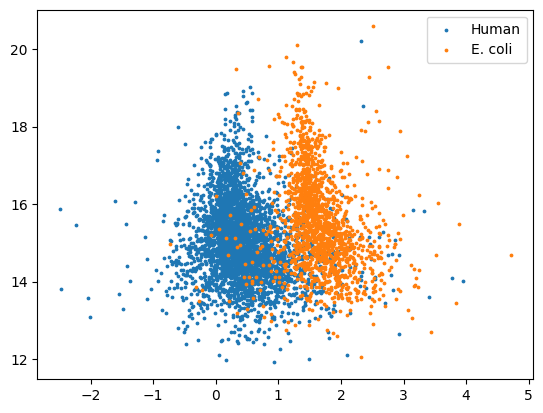

In [21]:
# _ = maxlfq(dataset=ds, molecule='protein', mapping='peptide-protein', partner_column='abundance', min_ratios=2, median_fallback=False, is_log=True, only_unique=True, result_column='abundance')

# #Plot the ratios to check whether we get two clusters (for human with log ratio around 0 and e. coli with log ratio around 1)
# vals = ds.get_values_flat('protein', molecule_columns='is_human')
# vals['is_low'] = vals.index.get_level_values('sample').str.contains('L')
# high, low = tuple([group.droplevel('is_low') for _,group in vals.groupby(['id', 'is_low']).median().groupby('is_low')])
# h_ecoli = high[~high.is_human.astype(bool)]
# l_ecoli = low[~low.is_human.astype(bool)]
# ecoli_median = (h_ecoli-l_ecoli).median()['abundance']
# h_human = high[high.is_human.astype(bool)]
# l_human = low[low.is_human.astype(bool)]
# fig, ax = plt.subplots()
# ax.scatter((h_human-l_human)['abundance'], ((h_human + l_human)['abundance'] / 2), s=3, label='Human')
# ax.scatter((h_ecoli-l_ecoli)['abundance'], ((h_ecoli + l_ecoli)['abundance'] / 2), s=3, label='E. coli')
# ax.legend()
# human_median = h_human.median()['abundance']-l_human.median()['abundance']
# print(f'E.coli ratio dist: {math.e**ecoli_median}')
# print(f'human ecoli ratio dist: {math.e**(ecoli_median - human_median)}')